## Set-up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
import os
os.chdir('drive/MyDrive/Colab Notebooks/histopathology-cancer-classification')
sys.path.append('src')

In [3]:
!ls

 data
 deep-set-and-gnn.ipynb
 deep-set-and-gnn-vote.ipynb
 deep-set-end-to-end.ipynb
 deep-set-from-extracted-features.ipynb
 deep-set.ipynb
 deep-set-multiple.ipynb
 deep-set-vote.ipynb
 feature_extraction.ipynb
 Graph_MIL.ipynb
 images
 model_checkpoint.pt
 README.md
 results.pickle
'Sean-testing-Copy of graph-neural-network.ipynb'
 single-patch.ipynb


In [4]:
!pip install torchinfo

In [5]:
!pip install imbalanced-learn==0.8.0

In [6]:
import time
import copy
import pickle
import math
import random
from PIL import Image
from pathlib import Path
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import imblearn
from tqdm.notebook import tqdm
from matplotlib import pylab as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch import optim, nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchinfo import summary

## Utility

In [7]:
def get_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Current device: {:s}".format(device.type))
    return device

In [8]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [9]:
def choose(a, b):
    return int(math.factorial(a) / math.factorial(a - b) / math.factorial(b))

In [10]:
def get_wsis_features_labels(root, files):
    all_wsis = []
    all_features = []
    all_labels = []
    for i, f in enumerate(files):
        path = root + '/' + f
        if not os.path.exists(path):
            print("{} does not exist!".format(path))
            continue
        infile = open(path, 'rb')
        raw = pickle.load(infile)
        for wsi, features in raw.items():
            all_wsis.append(wsi)
            all_features.append(list(features.values()))
            all_labels.append(i)
    all_wsis = np.array(all_wsis, dtype=object)
    all_features = np.array(all_features, dtype=object)
    all_labels = np.array(all_labels, dtype=int)
    return all_wsis, all_features, all_labels

In [11]:
def oversample_dataset(wsis, features, labels):
    smote = imblearn.over_sampling.SMOTE(
        # sampling_strategy={0:150, 1:156, 2:20},
        sampling_strategy='auto',
        random_state=seed,
        k_neighbors=3
    )
    indices = np.arange(len(labels))
    indices = np.reshape(indices, (-1, 1))
    indices_sm, labels_sm = smote.fit_resample(indices, labels)
    wsis_sm = wsis[indices_sm.flatten()]
    features_sm = features[indices_sm.flatten()]
    return wsis_sm, features_sm, labels_sm

In [12]:
def shuffle(wsis, features, labels):
    idx = np.random.permutation(len(wsis))
    return wsis[idx], features[idx], labels[idx]

In [13]:
def get_num_sets_for_dev(num_images, max_num_sets=50):
    if num_images <= num_patches:
        return 1
    num_combs = choose(num_images, num_patches)
    log_num_combs = math.log10(num_combs)
    return min(max_num_sets, max(1, math.ceil(log_num_combs)))

In [14]:
def get_random_sets(dataset, idx, num_sets):
    wsi, all_input_tensor, all_input_mask, all_label = dataset[idx]
    all_input_tensor = all_input_tensor.unsqueeze(0)
    all_input_mask = all_input_mask.unsqueeze(0)
    all_label = [all_label]
    for _ in range(num_sets - 1):
        _, input_tensor, input_mask, label = dataset[idx]
        all_input_tensor = torch.cat((all_input_tensor, input_tensor.unsqueeze(0)), dim=0)
        all_input_mask = torch.cat((all_input_mask, input_mask.unsqueeze(0)), dim=0)
        all_label.append(label)
    return wsi, all_input_tensor, all_input_mask, torch.LongTensor(all_label)

In [15]:
def plot_statistics(measure, values):
    fig = plt.figure(figsize=(10, 5))
    plt.title("Measure: {}".format(measure))
    for label, value in values.items():
        plt.plot(value, label=label)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(measure)
    plt.legend(loc='best')

In [16]:
def plot_cm(labels, preds):
    fig = plt.figure(figsize=(5, 5))
    cm = pd.crosstab(labels, preds,
                     rownames=['Actual'], colnames=['Predicted'],
                     normalize='index')
    cm = cm.rename(index = {0:'LUAD', 1:'LUSC', 2:'MESO'}, columns = {0:'LUAD', 1:'LUSC', 2:'MESO'})
    sns.heatmap(cm, annot=True,cmap='Blues', fmt=".1%")
    plt.show()

## Global

In [17]:
seed = 647

In [18]:
batch_size = 16

In [19]:
num_patches = 30

In [20]:
in_features = 1024

In [21]:
data_roots = {
    'train' : 'data/train',
    'dev' : 'data/dev'
}

In [22]:
data_files = {
    'train' : ['LUAD_256_features_maxpool.pickle',
               'LUSC_256_features_maxpool.pickle',
               'MESO_256_features_maxpool.pickle'],
    'dev' : ['LUAD_DEV_256_features_maxpool.pickle',
             'LUSC_DEV_256_features_maxpool.pickle',
             'MESO_DEV_256_features_maxpool.pickle']
}

In [23]:
device = get_device()

Current device: cuda


## Data

In [24]:
class HistoDataset(Dataset):
    def __init__(self, wsis, features, labels, num_patches):
        """
        @param wsis: WSI filenames
        @param features: 2D array of features
        @param labels: Labels - {0 : LUAD, 1 : LUSC, 2 : MESO}
        @param num_patches: Number of patches per set to return
        """
        self.wsis = wsis
        self.features = features
        self.labels = labels
        self.num_patches = num_patches
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        wsi, features, label = self.wsis[index], self.features[index], self.labels[index]
        if len(features) == 0:
            raise FileExistsError
        features = self._get_random_features(features)
        input_mask = self._get_input_mask(features)
        input_tensor = self._get_input_tensor(features)
        assert input_mask.shape[0] == self.num_patches
        assert input_tensor.shape[0] == self.num_patches
        return wsi, input_tensor, input_mask, label
    
    def _get_random_features(self, features):
        if len(features) <= self.num_patches:
            return random.sample(features, len(features))
        return random.sample(features, self.num_patches)
    
    def _get_input_mask(self, features):
        num_images = len(features)
        num_empties = self.num_patches - num_images
        return torch.BoolTensor([True] * num_images + [False] * num_empties)
    
    def _get_input_tensor(self, features):
        input_tensor = torch.stack(features, dim = 0)
        P, C = input_tensor.shape
        if P == self.num_patches:
            return input_tensor
        input_tensor_padded = torch.zeros(size=(self.num_patches, C))
        for i in range(P):
            input_tensor_padded[i] = input_tensor[i]
        return input_tensor_padded
    
    def get_num_images (self, index):
        wsi, features, label = self.wsis[index], self.features[index], self.labels[index]
        return len(features)

### Datasets

In [25]:
def create_dataset(root, files, oversample = True):
    wsis, features, labels = get_wsis_features_labels(root, files)
    if oversample:
        wsis, features, labels = oversample_dataset(wsis, features, labels)
    wsis, features, labels = shuffle(wsis, features, labels)
    dataset = HistoDataset(
        wsis = wsis,
        features = features,
        labels = labels,
        num_patches = num_patches
    )
    return dataset

In [26]:
set_seed(seed)

train_dataset = create_dataset(data_roots['train'], data_files['train'], oversample = True)
dev_dataset = create_dataset(data_roots['dev'], data_files['dev'], oversample = False)

In [27]:
Counter(train_dataset.labels)

Counter({0: 156, 1: 156, 2: 156})

In [28]:
Counter(dev_dataset.labels)

Counter({0: 38, 1: 41, 2: 5})

### EDA

In [29]:
all_patches = []

In [30]:
train_dataset_nos = create_dataset(data_roots['train'], data_files['train'], oversample = False)

In [31]:
for ds_type, dataset in zip(['train', 'dev'], [train_dataset, dev_dataset]):
    for i in range(len(dataset)):
        all_patches.append({
            'type' : ds_type,
            'label' : dataset.labels[i],
            'wsi_name' : dataset.wsis[i],
            'num_images' : dataset.get_num_images(i)
        })

In [32]:
df_eda = pd.DataFrame(all_patches)

In [33]:
pd.pivot_table(
    df_eda,
    values=['wsi_name', 'num_images'],
    index=['type', 'label'],
    aggfunc={
        'wsi_name' : np.count_nonzero,
        'num_images' : [('min',np.min),
                        ('mean', np.mean),
                        ('50th Pt',lambda x:np.percentile(x, 50, interpolation='higher')),
                        ('5th Pt',lambda x:np.percentile(x, 5, interpolation='higher')),
                        ('max',np.max)]
    }
)

num_images                                        wsi_name
               50th Pt 5th Pt     max        mean    min count_nonzero
type  label                                                           
dev   0          320.0   32.0   916.0  338.315789   24.0            38
      1          420.0   36.0  1188.0  438.243902    8.0            41
      2          304.0  228.0   904.0  396.000000  168.0             5
train 0          180.0   28.0  1132.0  293.871795   20.0           156
      1          408.0   44.0  1128.0  421.615385    8.0           156
      2           96.0    8.0   588.0  169.461538    8.0           156

### Dataloaders

In [34]:
train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = False
)

dev_dataloader = DataLoader(
    dataset = dev_dataset,
    batch_size = batch_size,
    shuffle = False
)

In [35]:
dataloaders = {
    'train' : train_dataloader,
    'dev' : dev_dataloader
}

In [36]:
for dtype, dl in dataloaders.items():
    print("{} has {} batches".format(dtype, len(dl)))

train has 30 batches
dev has 6 batches


### Example

In [37]:
ex_batch = next(iter(train_dataloader))

In [38]:
ex_input_tensors = ex_batch[1].to(device)

In [39]:
ex_input_tensors.shape

torch.Size([16, 30, 1024])

In [40]:
ex_input_masks = ex_batch[2].to(device)

In [41]:
ex_input_masks.shape

torch.Size([16, 30])

In [42]:
ex_labels = ex_batch[3].to(device)

In [43]:
ex_labels.shape

torch.Size([16])

In [44]:
ex_labels

tensor([1, 2, 1, 2, 1, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')

## Model

### Dense

In [45]:
class Dense(nn.Module):
  def __init__(self):
    super(Dense, self).__init__()
    self.fc1 = nn.Linear(in_features=in_features, out_features=512)
  
  def forward(self, x, mask=None):
    # x is in shape (batch_size, num_patches, 1024)
    x = self.fc1(x)
    x = torch.tanh(x)
    # transform mask into (batch_size, num_patches, 1)
    N, M, _ = x.shape
    device = x.device
    if mask is None:
        mask = torch.ones(N, M).byte().to(device)
    mask = mask.unsqueeze(-1).float()
    # we don't want to propogate on non-images
    x = x * mask
    return x

### Deep Set

In [46]:
class InvLinear(nn.Module):
    r"""Permutation invariant linear layer.
    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to False, the layer will not learn an additive bias.
            Default: ``True``
        reduction: Permutation invariant operation that maps the input set into a single
            vector. Currently, the following are supported: mean, sum, max and min.
    """
    def __init__(self, in_features, out_features, bias=True, reduction='mean'):
        super(InvLinear, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        assert reduction in ['mean', 'sum', 'max', 'min'],  \
            '\'reduction\' should be \'mean\'/\'sum\'\'max\'/\'min\', got {}'.format(reduction)
        self.reduction = reduction

        self.beta = nn.Parameter(torch.Tensor(self.in_features,
                                              self.out_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(1, self.out_features))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.beta)
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.beta)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, X, mask=None):
        r"""
        Maps the input set X = {x_1, ..., x_M} to a vector y of dimension out_features,
        through a permutation invariant linear transformation of the form:
            $y = \beta reduction(X) + bias$
        Inputs:
        X: N sets of size at most M where each element has dimension in_features
           (tensor with shape (N, M, in_features))
        mask: binary mask to indicate which elements in X are valid (byte tensor
            with shape (N, M) or None); if None, all sets have the maximum size M.
            Default: ``None``.
        Outputs:
        Y: N vectors of dimension out_features (tensor with shape (N, out_features))
        """
        N, M, _ = X.shape
        device = X.device
        y = torch.zeros(N, self.out_features).to(device)
        if mask is None:
            mask = torch.ones(N, M).byte().to(device)

        if self.reduction == 'mean':
            sizes = mask.float().sum(dim=1).unsqueeze(1)
            Z = X * mask.unsqueeze(2).float()
            y = (Z.sum(dim=1) @ self.beta)/sizes

        elif self.reduction == 'sum':
            Z = X * mask.unsqueeze(2).float()
            y = Z.sum(dim=1) @ self.beta

        elif self.reduction == 'max':
            Z = X.clone()
            Z[~mask] = float('-Inf')
            y = Z.max(dim=1)[0] @ self.beta

        else:  # min
            Z = X.clone()
            Z[~mask] = float('Inf')
            y = Z.min(dim=1)[0] @ self.beta

        if self.bias is not None:
            y += self.bias

        return y

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}, reduction={}'.format(
            self.in_features, self.out_features,
            self.bias is not None, self.reduction)

### Classifier

In [47]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # self.fc1 = nn.Linear(1024, 512)
        # self.d1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 128)
        self.d2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(128, 3)
    
    def forward(self, x):
        # x = self.fc1(x)
        # x = self.d1(x)
        # x = torch.relu(x)
        x = self.fc2(x)
        x = self.d2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        return x

### All

In [48]:
class HistoModel(nn.Module):
    
    def __init__(self):
        super(HistoModel, self).__init__()
        self.model_dense = Dense()
        self.model_ds = InvLinear(512, 512, bias=True, reduction='mean')
        self.model_mlp = MLP()
        
    def forward(self, x, mask=None):
        x = self.model_dense(x, mask)
        x = self.model_ds(x, mask)
        x = self.model_mlp(x)
        return x

In [49]:
my_model = HistoModel()
my_model = my_model.to(device)

In [50]:
summary(my_model, input_size=(batch_size, num_patches, in_features))

Layer (type:depth-idx)                   Output Shape              Param #
├─Dense: 1-1                             [16, 30, 512]             --
|    └─Linear: 2-1                       [16, 30, 512]             524,800
├─InvLinear: 1-2                         [16, 512]                 262,656
├─MLP: 1-3                               [16, 3]                   --
|    └─Linear: 2-2                       [16, 128]                 65,664
|    └─Dropout: 2-3                      [16, 128]                 --
|    └─Linear: 2-4                       [16, 3]                   387
Total params: 853,507
Trainable params: 853,507
Non-trainable params: 0
Total mult-adds (M): 264.27
Input size (MB): 1.97
Forward/backward pass size (MB): 2.05
Params size (MB): 3.41
Estimated Total Size (MB): 7.43

In [51]:
ex_outputs = my_model(ex_input_tensors, ex_input_masks)

In [52]:
ex_outputs.shape

torch.Size([16, 3])

In [53]:
ex_outputs

tensor([[ 0.2894, -0.1338, -0.0200],
        [ 0.2490, -0.1508, -0.3403],
        [ 0.2720, -0.2094, -0.0356],
        [ 0.3314,  0.1434, -0.1490],
        [ 0.0742,  0.1010,  0.0477],
        [ 0.4154, -0.3358, -0.0700],
        [ 0.2102,  0.0229, -0.0173],
        [ 0.2092,  0.0892,  0.0119],
        [ 0.1734, -0.2442, -0.0723],
        [ 0.2779, -0.0592, -0.1164],
        [ 0.3085, -0.0777, -0.1893],
        [ 0.2201, -0.1662, -0.0157],
        [ 0.3180, -0.1299, -0.1121],
        [ 0.2473, -0.0418, -0.2363],
        [ 0.2229, -0.1835, -0.3038],
        [ 0.1604, -0.0531,  0.0118]], device='cuda:0', grad_fn=<AddmmBackward>)

## Train

In [54]:
def train(model, device, train_dataloader, dev_dataset, criterion, optimizer, num_epochs):
    # starting time
    since = time.time()

    # store model that yields the highest accuracy in the dev set
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    best_dev_df = None

    # keep track of the statistics
    losses = {'train': [], 'dev': []}
    accuracies = {'train': [], 'dev': []}

    # iterate through each epoch
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # each epoch has a training and dev phase
        for phase in ['train', 'dev']:
            if phase == 'train':
                model.train()  # set model to training mode
            else:
                model.eval()   # set model to evaluate mode

            # loss and number of correct predictions
            running_loss = 0.0
            running_corrects = 0
            running_data = 0

            # training
            if phase == 'train':
                with tqdm(train_dataloader, unit="batch") as tepoch:
                    for batch in tepoch:
                        # Unravel inputs
                        _, inputs, masks, labels = batch
                        inputs = inputs.to(device)
                        masks = masks.to(device)
                        labels = labels.to(device)

                        # reset the parameter gradients
                        optimizer.zero_grad()
                        model.zero_grad()

                        # forward
                        # track history only in train
                        with torch.set_grad_enabled(True):
                            outputs = model(inputs, masks)
                            outputs = outputs.to(device)
                            loss = criterion(outputs, labels)
                            preds = torch.argmax(outputs, axis=1)

                            loss.backward()
                            optimizer.step()
                            
                            # record

                        # add to statistics
                        running_loss += loss.item() * len(labels)
                        running_corrects += torch.sum(
                            preds == labels.data.flatten()
                        ).item()
                        running_data += len(labels)

                        # update progress bar
                        tepoch.set_postfix(
                            loss=(running_loss / running_data),
                            accuracy=(running_corrects / running_data)
                        )
                        time.sleep(0.1)
            
            # dev
            else:
                dev_df = predict(model, device, dev_dataset, criterion)
                running_loss = np.sum(dev_df['loss'])
                running_corrects = np.sum(dev_df['correct'])
                running_data = len(dev_df)

            # compute loss and accuracy at epoch level
            epoch_loss = running_loss / running_data
            epoch_acc = running_corrects / running_data
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)

            print('{} Loss: {:.4f}; Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc
            ))

            # deep copy the model when epoch accuracy (on dev set) is the best so far
            if phase == 'dev' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch + 1
                best_dev_df = dev_df
                torch.save(model, 'model_checkpoint.pt')
                print('Best model so far! Saved checkpoint.')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    ))
    print('Best Dev Acc: {:4f} at Epoch: {:d}'.format(best_acc, best_epoch))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_epoch, losses, accuracies, best_dev_df

In [55]:
def predict(model, device, dataset, criterion):
    # initialize return df
    df = pd.DataFrame(columns = ['wsi', 'label', 'vote_0', 'vote_1', 'vote_2', 'pred', 'correct', 'loss'])

    # set to eval mode
    model = model.eval()

    # total number of WSIs in dataset
    num_wsis = len(dataset)

    # iterate through each WSI
    with tqdm(total = num_wsis) as pbar:
        for i in range(num_wsis):
            # compute optimal number of sets for voting
            num_images = dev_dataset.get_num_images(i)
            num_sets = get_num_sets_for_dev(num_images, max_num_sets=50)

            # get random sets
            wsi, inputs, masks, labels = get_random_sets(dataset, i, num_sets)
            inputs = inputs.to(device)
            masks = masks.to(device)
            labels = labels.to(device)

            # actual number of sets
            num_sets = len(labels)

            # forward
            with torch.set_grad_enabled(False):
                outputs = model(inputs, masks)
                outputs = outputs.to(device)
                loss = criterion(outputs, labels)
                preds = torch.argmax(outputs, axis=1)

            # count votes
            votes = Counter(preds.cpu().numpy())

            # majority vote is the prediction
            pred = votes.most_common()[0][0]
            label = labels.cpu().numpy()[0]

            # update df
            df.loc[i] = [wsi, label,
                        votes[0], votes[1], votes[2],
                        pred, label == pred, loss.item()]
            
            # update progress bar
            pbar.update(1)
            pbar.set_postfix(
                loss=(np.sum(df['loss']) / len(df)),
                accuracy=(np.sum(df['correct']) / len(df))
            )
            time.sleep(0.1)
    
    return df

In [56]:
my_model = HistoModel()
my_model = my_model.to(device)

In [57]:
optimizer = optim.AdamW(
    my_model.parameters(),
    lr = 1e-6
)

In [58]:
criterion = nn.CrossEntropyLoss(weight = torch.FloatTensor([10, 10, 10]))
# criterion = nn.CrossEntropyLoss()

criterion = criterion.to(device)

In [59]:
set_seed(seed)

my_model, best_epoch, losses, accuracies, best_dev_df = train(
    model = my_model,
    device = device,
    train_dataloader = train_dataloader,
    dev_dataset = dev_dataset,
    criterion = criterion,
    optimizer = optimizer,
    num_epochs = 50
)

Epoch 1/50
----------



train Loss: 1.1019; Acc: 0.3098



dev Loss: 1.0940; Acc: 0.3810
Best model so far! Saved checkpoint.

Epoch 2/50
----------



train Loss: 1.1023; Acc: 0.3141



dev Loss: 1.0907; Acc: 0.4881
Best model so far! Saved checkpoint.

Epoch 3/50
----------



train Loss: 1.0956; Acc: 0.3675



dev Loss: 1.0892; Acc: 0.5000
Best model so far! Saved checkpoint.

Epoch 4/50
----------



train Loss: 1.0943; Acc: 0.3440



dev Loss: 1.0877; Acc: 0.5000

Epoch 5/50
----------



train Loss: 1.0925; Acc: 0.3547



dev Loss: 1.0868; Acc: 0.5000

Epoch 6/50
----------



train Loss: 1.0891; Acc: 0.4060



dev Loss: 1.0845; Acc: 0.5119
Best model so far! Saved checkpoint.

Epoch 7/50
----------



train Loss: 1.0796; Acc: 0.4017



dev Loss: 1.0820; Acc: 0.5595
Best model so far! Saved checkpoint.

Epoch 8/50
----------



train Loss: 1.0786; Acc: 0.4188



dev Loss: 1.0802; Acc: 0.5952
Best model so far! Saved checkpoint.

Epoch 9/50
----------



train Loss: 1.0761; Acc: 0.4380



dev Loss: 1.0786; Acc: 0.5714

Epoch 10/50
----------



train Loss: 1.0718; Acc: 0.4658



dev Loss: 1.0781; Acc: 0.5833

Epoch 11/50
----------



train Loss: 1.0764; Acc: 0.4295



dev Loss: 1.0770; Acc: 0.5833

Epoch 12/50
----------



train Loss: 1.0671; Acc: 0.5064



dev Loss: 1.0755; Acc: 0.5952

Epoch 13/50
----------



train Loss: 1.0630; Acc: 0.5128



dev Loss: 1.0751; Acc: 0.5952

Epoch 14/50
----------



train Loss: 1.0648; Acc: 0.5000



dev Loss: 1.0745; Acc: 0.6071
Best model so far! Saved checkpoint.

Epoch 15/50
----------



train Loss: 1.0601; Acc: 0.5085



dev Loss: 1.0727; Acc: 0.6190
Best model so far! Saved checkpoint.

Epoch 16/50
----------



train Loss: 1.0612; Acc: 0.5000



dev Loss: 1.0718; Acc: 0.6190

Epoch 17/50
----------



train Loss: 1.0567; Acc: 0.5449



dev Loss: 1.0705; Acc: 0.6310
Best model so far! Saved checkpoint.

Epoch 18/50
----------



train Loss: 1.0543; Acc: 0.5406



dev Loss: 1.0692; Acc: 0.6071

Epoch 19/50
----------



train Loss: 1.0537; Acc: 0.5342



dev Loss: 1.0666; Acc: 0.6310

Epoch 20/50
----------



train Loss: 1.0473; Acc: 0.5427



dev Loss: 1.0672; Acc: 0.6310

Epoch 21/50
----------



train Loss: 1.0424; Acc: 0.5705



dev Loss: 1.0665; Acc: 0.6310

Epoch 22/50
----------



train Loss: 1.0476; Acc: 0.5513



dev Loss: 1.0642; Acc: 0.6310

Epoch 23/50
----------



train Loss: 1.0419; Acc: 0.5620



dev Loss: 1.0636; Acc: 0.6310

Epoch 24/50
----------



train Loss: 1.0439; Acc: 0.5833



dev Loss: 1.0635; Acc: 0.6310

Epoch 25/50
----------



train Loss: 1.0349; Acc: 0.5919



dev Loss: 1.0629; Acc: 0.6190

Epoch 26/50
----------



train Loss: 1.0336; Acc: 0.5940



dev Loss: 1.0617; Acc: 0.6429
Best model so far! Saved checkpoint.

Epoch 27/50
----------



train Loss: 1.0319; Acc: 0.6090



dev Loss: 1.0612; Acc: 0.6310

Epoch 28/50
----------



train Loss: 1.0316; Acc: 0.6090



dev Loss: 1.0591; Acc: 0.6429

Epoch 29/50
----------



train Loss: 1.0269; Acc: 0.6239



dev Loss: 1.0568; Acc: 0.6310

Epoch 30/50
----------



train Loss: 1.0288; Acc: 0.6346



dev Loss: 1.0556; Acc: 0.6310

Epoch 31/50
----------



train Loss: 1.0244; Acc: 0.6410



dev Loss: 1.0542; Acc: 0.6310

Epoch 32/50
----------



train Loss: 1.0209; Acc: 0.6239



dev Loss: 1.0531; Acc: 0.6310

Epoch 33/50
----------



train Loss: 1.0203; Acc: 0.6368



dev Loss: 1.0520; Acc: 0.6310

Epoch 34/50
----------



train Loss: 1.0153; Acc: 0.6218



dev Loss: 1.0524; Acc: 0.6310

Epoch 35/50
----------



train Loss: 1.0098; Acc: 0.6560



dev Loss: 1.0511; Acc: 0.6429

Epoch 36/50
----------



train Loss: 1.0136; Acc: 0.6197



dev Loss: 1.0501; Acc: 0.6190

Epoch 37/50
----------



train Loss: 1.0090; Acc: 0.6432



dev Loss: 1.0488; Acc: 0.6310

Epoch 38/50
----------



train Loss: 1.0115; Acc: 0.6538



dev Loss: 1.0479; Acc: 0.6310

Epoch 39/50
----------



train Loss: 1.0045; Acc: 0.6667



dev Loss: 1.0470; Acc: 0.6310

Epoch 40/50
----------



train Loss: 1.0024; Acc: 0.6538



dev Loss: 1.0466; Acc: 0.6429

Epoch 41/50
----------



train Loss: 0.9980; Acc: 0.6752



dev Loss: 1.0455; Acc: 0.6429

Epoch 42/50
----------



train Loss: 0.9969; Acc: 0.6624



dev Loss: 1.0442; Acc: 0.6429

Epoch 43/50
----------



train Loss: 0.9923; Acc: 0.6731



dev Loss: 1.0436; Acc: 0.6310

Epoch 44/50
----------



train Loss: 0.9928; Acc: 0.6538



dev Loss: 1.0434; Acc: 0.6310

Epoch 45/50
----------



train Loss: 0.9920; Acc: 0.6645



dev Loss: 1.0417; Acc: 0.6310

Epoch 46/50
----------



train Loss: 0.9860; Acc: 0.6795



dev Loss: 1.0412; Acc: 0.6310

Epoch 47/50
----------



train Loss: 0.9869; Acc: 0.6838



dev Loss: 1.0396; Acc: 0.6310

Epoch 48/50
----------



train Loss: 0.9790; Acc: 0.6987



dev Loss: 1.0381; Acc: 0.6310

Epoch 49/50
----------



train Loss: 0.9744; Acc: 0.7094



dev Loss: 1.0371; Acc: 0.6310

Epoch 50/50
----------



train Loss: 0.9825; Acc: 0.6624



dev Loss: 1.0359; Acc: 0.6310

Training complete in 12m 10s
Best Dev Acc: 0.642857 at Epoch: 26


### Results

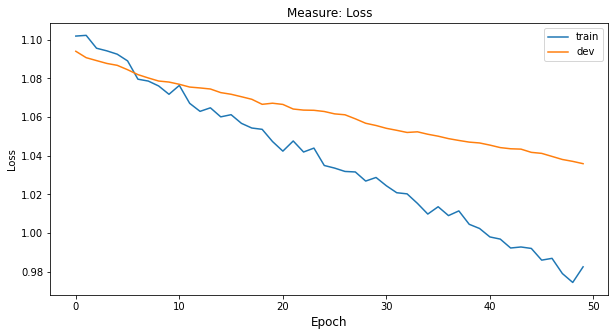

In [60]:
plot_statistics('Loss', losses)

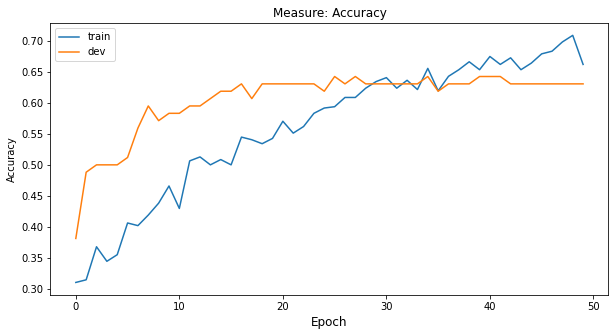

In [61]:
plot_statistics('Accuracy', accuracies)

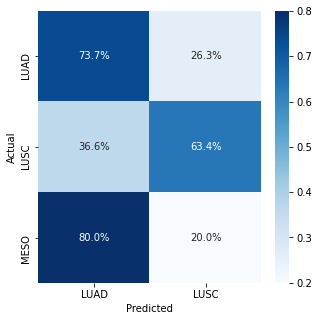

In [62]:
plot_cm(best_dev_df['label'], best_dev_df['pred'])